In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [3]:
dealer_data = pd.read_csv('dealer/dealer_data.csv')

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (75,76,77,78,79,105,106,122,123,128,130,132,134,171,172,178,189) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# List of relevant columns, including the recovery rate
relevant_columns = [
    'Date', 'DealCSP', 'PrimaryDealer', 'C2D_Dealer', 'TradeSize', 'C2Ctrades', 'C2Dvolume_PAR', 
    'TradePreCount', 'TradePreVolume', 'TimeToMaturity', 'TimeSinceOffering', 'Default', 
    'TRADE_CHAIN2', 'TRADE_CHAIN3', 'TRADE_CHAIN4', 'TRADE_CHAIN5', 'TRADE_CHAIN6', 'TRADE_CHAIN7', 'TRADE_CHAIN8', 'TRADE_CHAIN9', 'TRADE_CHAIN10',
    'Markup', 'predicted_Primary', 'Rating', 'Commission', 'PostDummy', 'IndustryDefaultRate', 
    'UncertaintyIndex', 'PriceDistance', 'RR_Price'
]

# Limit the DataFrame to the relevant columns
dealer_df_limited = dealer_data[relevant_columns]

# rename DealCSP to CUSIP
dealer_df_limited.rename(columns={'DealCSP': 'CUSIP'}, inplace=True)

# rename RR_price to dealer_RR
dealer_df_limited.rename(columns={'RR_Price': 'dealer_RR'}, inplace=True)

# transform the date column to date
dealer_df_limited['Date'] = pd.to_datetime(dealer_df_limited['Date'])

# ingore time
dealer_df_limited['Date'] = dealer_df_limited['Date'].dt.date

# Display the first few rows of the limited DataFrame
dealer_df_limited.head()

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/var/folders/jx/r9zzxsjd7wxgmmn32r0l8cz40000gn/T/ipykernel_15087/2429905732.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dealer_df_limited['Date'] = pd.to_datetime(dealer_df_limited['Date'])
/var/folders/jx/r9zzxsjd7wxgmmn32r0l8cz40000gn/T/ipykernel_15087/2429905732.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,Date,CUSIP,PrimaryDealer,C2D_Dealer,TradeSize,C2Ctrades,C2Dvolume_PAR,TradePreCount,TradePreVolume,TimeToMaturity,...,TRADE_CHAIN10,Markup,predicted_Primary,Rating,Commission,PostDummy,IndustryDefaultRate,UncertaintyIndex,PriceDistance,dealer_RR
0,2012-10-24,00126VAB6,0.0,9ea411b1b98cf4084186ab303328c358f2189128,Retail,4.0,10000.0,97.0,33307000.0,6.622163,...,NaN,0.002085,0.151936,17.0,0.002085,1.0,0.832444,275.808527,-0.064324437,47.9600
1,2012-10-25,00126VAB6,0.0,df8e2728f63ee1112e65ccc34a2e6dd006d9825e,SmallInstitutional,0.0,965000.0,98.0,33317000.0,6.620745,...,NaN,-1.000000,0.007963,17.0,NaN,1.0,0.832444,275.808527,-0.024456522,46.0000
2,2012-10-25,00126VAB6,0.0,9ea411b1b98cf4084186ab303328c358f2189128,Retail,4.0,10000.0,98.0,33317000.0,6.620559,...,NaN,0.002085,0.151791,17.0,0.002085,1.0,0.832444,275.808527,-0.064324437,47.9600
3,2012-10-26,00126VAB6,0.0,9ea411b1b98cf4084186ab303328c358f2189128,Retail,4.0,10000.0,99.0,34282000.0,6.619243,...,NaN,0.004168,0.151671,17.0,0.004168,1.0,0.832444,275.808527,-0.062379206,47.8605
4,2012-11-05,00126VAB6,0.0,4453917d43ee60954c145536e3ea07bc15324c59,LargeInstitutional,2.0,1000000.0,100.0,34292000.0,6.605873,...,NaN,0.005464,0.076537,17.0,0.005464,1.0,0.832444,245.097169,-0.019125683,45.7500


In [5]:
presentation_analysis = pd.read_csv('transcripts/LLM_outputs_presentation.csv')
qna_analysis = pd.read_csv('transcripts/LLM_QnA_analysis.csv')

# Add GoEmotions labels to the llm_output
emotions_presentation = pd.read_csv('goemotions/presentation_summary_final.csv', delimiter='|')
emotions_qna = pd.read_csv('goemotions/qna_summary_final.csv', delimiter='|')
emotions_analysts = pd.read_csv('goemotions/analysts_summary_final.csv', delimiter='|')

presentation_labels = ['negative_sentiment', 'positive_sentiment', 'uncertainty', 'optimistic', 'pessimistic', 'vagueness', 'language_accessibility_presentation',
              'liquidity_position', 'debt_leverage_stress', 'operational_trends', 'industry_positioning', 'asset_quality', 'recovery_strategies', 'legal_issues','macroeconomic']

qna_labels = ['analyst_concerns', 'responsiveness', 'confidence', 'evasiveness', 'depth', 'analyst_satisfaction', 'language_accessibility_qna']

qna_mgmt = ['responsiveness', 'confidence', 'depth', 'evasiveness', 'language_accessibility_qna']
qna_analysts = ['analyst_concerns', 'analyst_satisfaction']

emotions = [
        'admiration', 
        #'amusement', 
        'anger', 
        'annoyance', 
        'approval', 
        'caring', 
        'confusion', 
        'curiosity', 
        'desire',
        'disappointment', 
        'disapproval', 
        #'disgust', 
        'embarrassment', 
        'excitement', 
        'fear', 
        #'gratitude', 
        #'grief',
        'joy', 
        #'love', 
        'nervousness', 
        'optimism', 
        'pride', 
        'realization', 
        'relief', 
        'remorse', 
        'sadness', 
        'surprise'
    ]

analyst_emotions = []
for i in emotions:
    analyst_emotions.append(i + '_analysts')

In [69]:
SEPARATE = False

presentation_analysis.rename(columns={'language_accessibility': 'language_accessibility_presentation'}, inplace=True)
qna_analysis.rename(columns={'language_accessibility': 'language_accessibility_qna'}, inplace=True)

qna_analysis = qna_analysis[["call_ID"] + qna_labels]
qna_analysis.drop_duplicates(keep='first', inplace=True)
emotions_presentation = emotions_presentation[["call_ID"] + emotions]
emotions_presentation.drop_duplicates(keep='first', inplace=True)
emotions_qna = emotions_qna[["call_ID"] + emotions]
emotions_qna.drop_duplicates(keep='first', inplace=True)
emotions_analysts = emotions_analysts[["call_ID"] + emotions]
emotions_analysts.drop_duplicates(keep='first', inplace=True)

# add qna_labels to the llm_output
llm_output = pd.merge(presentation_analysis, qna_analysis, on='call_ID', how='left')
llm_output = pd.merge(llm_output, emotions_presentation, on='call_ID', how='left')
llm_output = pd.merge(llm_output, emotions_qna, on='call_ID', how='left')

if not SEPARATE:
    for emotion in emotions:
        llm_output[emotion] = llm_output[f'{emotion}_x'] + llm_output[f'{emotion}_y']
        llm_output.drop([f'{emotion}_x', f'{emotion}_y'], axis=1, inplace=True)
        scaler = MinMaxScaler()
        llm_output[emotion] = scaler.fit_transform(llm_output[[emotion]])

llm_output = pd.merge(llm_output, emotions_analysts, on='call_ID', how='left')

# rename emotions_x to emotions and emotions_y to emotions_analysts
for emotion in emotions:
    llm_output.rename(columns={f'{emotion}_x': f'{emotion}', f'{emotion}_y': f'{emotion}_analysts'}, inplace=True)

llm_output.head()

,RR,ActIndustryDistress1,ActIndustryDistress2,Senior secured,Senior unsecured,Senior subordinated,Subordinated \& Junior,Equity value,Default barrier,Net income margin,...,fear_analysts,joy_analysts,nervousness_analysts,optimism_analysts,pride_analysts,realization_analysts,relief_analysts,remorse_analysts,sadness_analysts,surprise_analysts
0,29.023972,0,1,0,1,0,0,635.12600,0.173560,-0.026785,...,0.000000,0.000000,0.0,0.966905,0.0,0.145973,0.0,0.0,0.0,0.457073
1,8.869420,1,0,0,1,0,0,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.151184,0.0,0.000000,0.0,0.0,0.0,0.000000
2,33.210455,0,0,0,1,0,0,228.77559,0.000000,0.000000,...,0.000000,0.642977,0.0,0.082452,0.0,0.030370,0.0,0.0,0.0,0.607991
3,11.875000,0,0,0,0,1,0,-91.83100,1.053145,-0.375589,...,0.313183,0.000000,0.0,0.230339,0.0,0.164301,0.0,0.0,0.0,0.118028
4,18.340000,0,0,0,1,0,0,-96.67500,0.679972,-0.060670,...,0.000000,0.000000,0.0,0.212880,0.0,0.062939,0.0,0.0,0.0,0.000000


In [70]:
dealer_df = pd.merge(dealer_df_limited, llm_output, on='CUSIP', how='inner')

In [71]:
# transform Date_y to date
dealer_df['Date_y'] = pd.to_datetime(dealer_df['Date_y'])

# drop all rows where Date_x < Date_y
dealer_df = dealer_df[dealer_df['Date_x'] >= dealer_df['Date_y']]

In [72]:
# List of trade chain columns
trade_chain_cols = ['TRADE_CHAIN2', 'TRADE_CHAIN3', 'TRADE_CHAIN4', 'TRADE_CHAIN5', 'TRADE_CHAIN6', 'TRADE_CHAIN7', 'TRADE_CHAIN8', 'TRADE_CHAIN9', 'TRADE_CHAIN10']

# Calculate chain length
dealer_df['transaction_chain_length'] = dealer_df[trade_chain_cols].notna().sum(axis=1) + 1  # +1 for the initial trade

In [73]:
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

In [87]:
def create_colored_chart(model):

    # Filter significant features
    significant_features = model.pvalues[model.pvalues < 0.05].index
    importances = model.params[significant_features]  # Only significant features
    importances = importances[1:]

    # Sort importances by their absolute value, and select the top 10
    top_12_importances = importances.abs().sort_values(ascending=False).head(10)
    importances = importances[top_12_importances.index]
    importances = importances.sort_values()  # Sort the values for better visualization

    # Define emotion types (assuming the feature names match these emotion labels)
    emotion_types = {
        'relief': 'positive',
        'remorse': 'negative',
        'nervousness': 'negative',
        'desire': 'positive',
        'fear': 'strong_negative',
        'excitement': 'positive',
        'confusion': 'negative',
        'pride': 'positive',
        'annoyance': 'negative',
        'gratitude': 'positive',
        'anger': 'strong_negative',
        'optimism': 'positive',
        'sadness': 'negative', 
        'approval': 'positive',
        'caring': 'positive',
        'disappointment': 'negative',
        'curiosity': 'positive',
        'surprise': 'positive',
        'admiration': 'positive',
        'embarrassment': 'negative',
        'realization': 'positive',
        'disapproval': 'negative',
        'joy': 'positive',
        'relief_analysts': 'positive',
        'remorse_analysts': 'negative',
        'nervousness_analysts': 'negative',
        'desire_analysts': 'positive',
        'fear_analysts': 'strong_negative',
        'excitement_analysts': 'positive',
        'confusion_analysts': 'negative',
        'pride_analysts': 'positive',
        'annoyance_analysts': 'negative',
        'gratitude_analysts': 'positive',
        'anger_analysts': 'strong_negative',
        'optimism_analysts': 'positive',
        'sadness_analysts': 'negative',
        'approval_analysts': 'positive',
        'caring_analysts': 'positive',
        'disappointment_analysts': 'negative',
        'curiosity_analysts': 'positive',
        'surprise_analysts': 'positive',
        'admiration_analysts': 'positive',
        'embarrassment_analysts': 'negative',
        'realization_analysts': 'positive',
        'disapproval_analysts': 'negative',
        'joy_analysts': 'positive'
    }

    # Map colors to each emotion type
    color_mapping = {
        'positive': 'green',
        'strong_negative': 'red',
        'negative': 'gray',
    }

    # Apply the color mapping to the top 12 significant features
    colors = []
    for feature in importances.index:
        if feature in supporting_features_1 or feature in supporting_features_2:
            colors.append('blue')
        elif feature in presentation_labels or feature in qna_labels:
            colors.append('orange')
        elif feature in emotion_types:
            colors.append(color_mapping[emotion_types[feature]])
        else:
            colors.append('black')  # Default for unknown features

    # Create a horizontal bar plot for the top 12 significant features
    plt.figure(figsize=(10, 5))
    plt.barh(importances.index, importances.values, color=colors)

    # Add labels and title
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title('Remaining Significant Features and their Impact')

    # Create a custom legend
    handles = [
        plt.Rectangle((0, 0), 1, 1, color='blue'),
        plt.Rectangle((0, 0), 1, 1, color='orange'),
        plt.Rectangle((0, 0), 1, 1, color='green'), plt.Rectangle((0, 0), 1, 1, color='gray'), plt.Rectangle((0, 0), 1, 1, color='red')
    ]
    labels = [
            'Financial Data', 
            'LLM Labels', 
            'Positive Emotion', 'Negative Emotion', 'Strong Negative Emotion'
            ]

    # Add the legend
    plt.legend(handles, labels)

    # Show the plot
    return plt.show()


def create_significant_chart(model):

    # select significant features
    model.significance = model.pvalues[model.pvalues < 0.05].index

    # build a graph to show the importance of each feature
    importances = model.params[1:]
    importances = importances.sort_values()

    # Sort the importance values based on absolute values, not just positive or negative
    top_10_importances = importances.abs().sort_values(ascending=False).head(10)

    # reduce importances to only the top 10
    importances = importances[top_10_importances.index]
    importances = importances.sort_values()

    # color significant features 0/150/130 and others in grey
    colors = ['#009682' if feature in model.significance else 'grey' for feature in importances.index]

    plt.figure(figsize=(10, 5))
    plt.barh(importances.index, importances.values, color=colors)
    # add legend
    plt.legend(['Significant', 'Not Significant'])
    plt.xlabel('Impact')
    plt.ylabel('Features')
    plt.title('Features Impact on Recovery Rate')
    return plt.show()

In [94]:
'''SET FEATURES'''

# Select the supporting features, nlp_lables, and RR from final_df
selected_df = dealer_df[['dealer_RR', 'PrimaryDealer', 'transaction_chain_length']
                    + supporting_features_1
                    + supporting_features_2
                    + presentation_labels 
                    + qna_labels
                    #+ qna_mgmt
                    #+ qna_analysts
                    + emotions
                    + analyst_emotions
                    ]

# reset index
selected_df_df = selected_df.reset_index(drop=True)

                            OLS Regression Results                            
Dep. Variable:              dealer_RR   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     1286.
Date:                Thu, 24 Oct 2024   Prob (F-statistic):               0.00
Time:                        17:35:17   Log-Likelihood:            -1.0053e+05
No. Observations:               35535   AIC:                         2.012e+05
Df Residuals:                   35443   BIC:                         2.020e+05
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

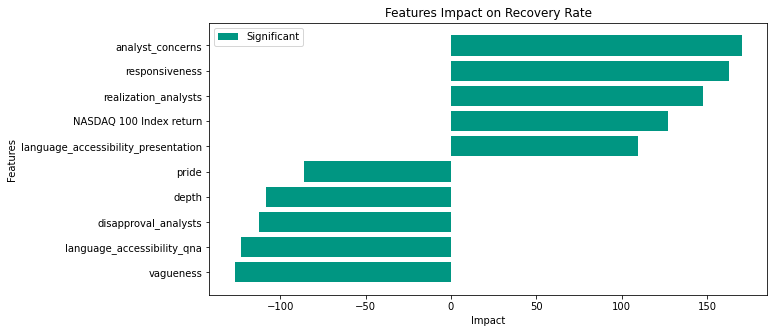

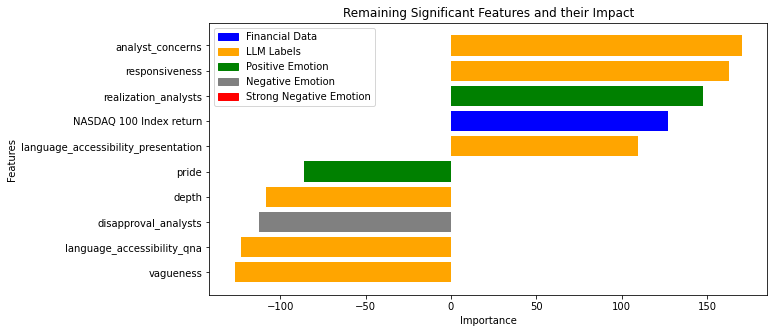

In [95]:
'''Dealer Recovery Rate Prediction'''
'''PRIMARY DEALER'''
final_df = selected_df[selected_df['PrimaryDealer'] == 1]

y_train, y_test = final_df['dealer_RR'], final_df['dealer_RR']
X_train, X_test = final_df.drop(columns=['dealer_RR', 'PrimaryDealer', 'transaction_chain_length']), final_df.drop(columns=['dealer_RR', 'PrimaryDealer', 'transaction_chain_length'])

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

create_significant_chart(model)
create_colored_chart(model)

                            OLS Regression Results                            
Dep. Variable:              dealer_RR   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     1572.
Date:                Thu, 24 Oct 2024   Prob (F-statistic):               0.00
Time:                        17:35:18   Log-Likelihood:            -1.7094e+05
No. Observations:               45934   AIC:                         3.421e+05
Df Residuals:                   45841   BIC:                         3.429e+05
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

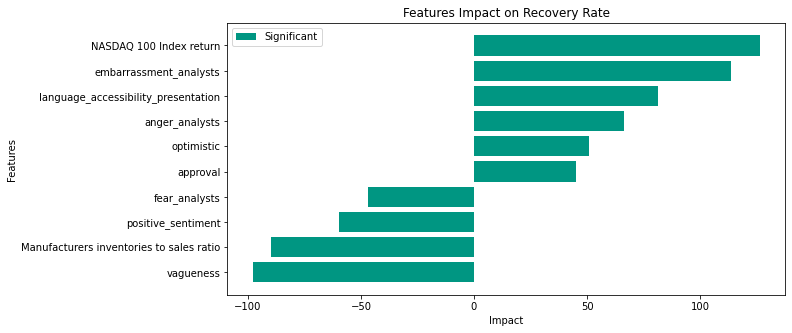

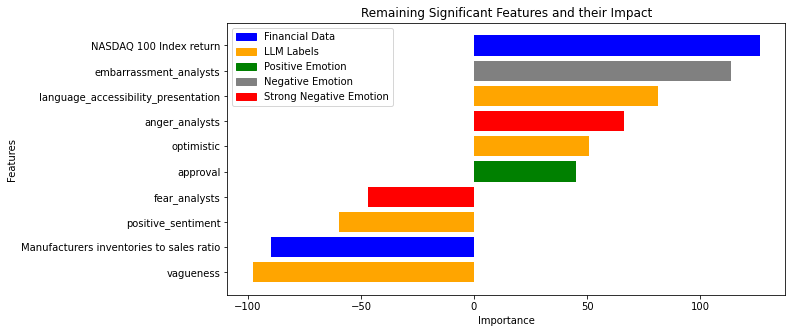

In [96]:
'''Dealer Recovery Rate Prediction'''
'''NON-PRIMARY DEALER'''
final_df = selected_df[selected_df['PrimaryDealer'] == 0]

y_train, y_test = final_df['dealer_RR'], final_df['dealer_RR']
X_train, X_test = final_df.drop(columns=['dealer_RR', 'PrimaryDealer', 'transaction_chain_length']), final_df.drop(columns=['dealer_RR', 'PrimaryDealer', 'transaction_chain_length'])

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

create_significant_chart(model)
create_colored_chart(model)

                               OLS Regression Results                               
Dep. Variable:     transaction_chain_length   R-squared:                       0.149
Model:                                  OLS   Adj. R-squared:                  0.149
Method:                       Least Squares   F-statistic:                     168.6
Date:                      Thu, 24 Oct 2024   Prob (F-statistic):               0.00
Time:                              17:07:42   Log-Likelihood:                -8478.2
No. Observations:                     35535   AIC:                         1.703e+04
Df Residuals:                         35497   BIC:                         1.735e+04
Df Model:                                37                                         
Covariance Type:                  nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

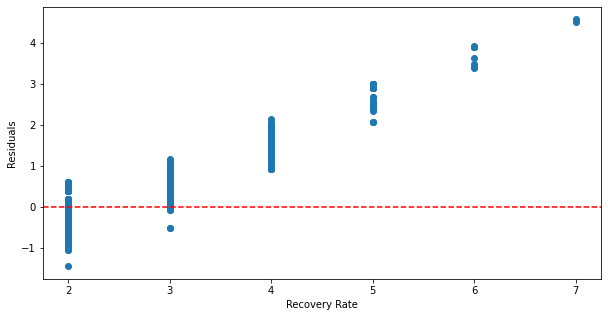

In [19]:
'''Transaction Chain Length Prediction'''
# In-Sample-Regression: Transaction Chain Length
y_train, y_test = final_df['transaction_chain_length'], final_df['transaction_chain_length']
X_train, X_test = final_df.drop(columns=['dealer_RR', 'PrimaryDealer', 'transaction_chain_length']), final_df.drop(columns=['dealer_RR', 'PrimaryDealer', 'transaction_chain_length'])

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

# other metric
# Calculate the residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Recovery Rate')
plt.ylabel('Residuals')

# Display the plot
plt.show()

In [ ]:
# Compute variance inflation factor 
vif = pd.DataFrame()
vif["Features"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)

# Display the VIF
print(vif)

In [ ]:
# select significant features
model.significance = model.pvalues[model.pvalues < 0.05].index

# build a graph to show the importance of each feature
importances = model.params[1:]
importances = importances.sort_values()

# Sort the importance values based on absolute values, not just positive or negative
top_10_importances = importances.abs().sort_values(ascending=False).head(15)

# reduce importances to only the top 10
importances = importances[top_10_importances.index]
importances = importances.sort_values()

# color significant features 0/150/130 and others in grey
colors = ['#009682' if feature in model.significance else 'grey' for feature in importances.index]

plt.figure(figsize=(10, 5))
plt.barh(importances.index, importances.values, color=colors)
# add legend
plt.legend(['Significant', 'Not Significant'])
plt.xlabel('Impact')
plt.ylabel('Features')
plt.title('Features Impact on Recovery Rate')
plt.show()

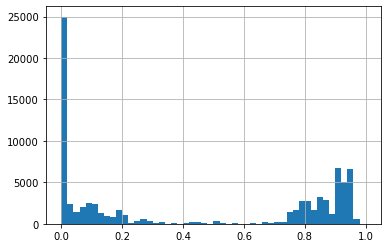

In [98]:
'''Primary Dealer Classification'''
'''Is the probability of being a primary dealer related to earnings call features?'''

# percentage of trades per CUSIP that are primary dealer trades
dealer_df['count_primary_dealer'] = dealer_df.groupby('CUSIP')['PrimaryDealer'].transform('sum')
dealer_df['count_total'] = dealer_df.groupby('CUSIP')['PrimaryDealer'].transform('count')
dealer_df['percentage_primary_dealer'] = dealer_df['count_primary_dealer'] / dealer_df['count_total']

# drop the count columns
dealer_df.drop(columns=['count_primary_dealer', 'count_total'], inplace=True)

# show distribution of the new feature
dealer_df['percentage_primary_dealer'].hist(bins=50)

# convert percentage_primary_dealer to a binary feature
dealer_df['by_primary_dealer'] = dealer_df['percentage_primary_dealer'].apply(lambda x: 1 if x > 0.5 else 0)

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

logreg = LogisticRegression(class_weight='balanced')
svm = SVC(class_weight='balanced')
forest = RandomForestClassifier(class_weight='balanced')

feature_sets = {'Financial Data 1': supporting_features_1, 
                'Financial Data 1&2': supporting_features_1 + supporting_features_2,
                ## Earnings call features
                'Presentation Labels': presentation_labels, 
                'Q&A Labels':qna_labels, 
                'Management Emotions': emotions, 
                'Analyst Emotions': analyst_emotions,
                'LLM Labels': presentation_labels + qna_labels,
                'All Emotions': emotions + analyst_emotions,
                'All Earnings call': presentation_labels + qna_labels + emotions + analyst_emotions,
                ## Earnings call features and financial data
                'Financial Data 1&2 & Presentation Labels': supporting_features_1 + supporting_features_2 + presentation_labels,
                'Financial Data 1&2 & Q&A Labels': supporting_features_1 + supporting_features_2 + qna_labels,
                'Financial Data 1&2 & Management Emotions': supporting_features_1 + supporting_features_2 + emotions,
                'Financial Data 1&2 & Analyst Emotions': supporting_features_1 + supporting_features_2 + analyst_emotions,
                'Financial Data 1&2 & LLM Labels': supporting_features_1 + supporting_features_2 + presentation_labels + qna_labels,
                'Financial Data 1&2 & All Emotions': supporting_features_1 + supporting_features_2 + emotions + analyst_emotions,
                'Financial Data 1&2 & All Earnings call': supporting_features_1 + supporting_features_2 + presentation_labels + qna_labels + emotions + analyst_emotions
                }

for key in feature_sets:
    # Set features (earnings call features) and target (PrimaryDealer)
    final_df = dealer_df[['by_primary_dealer'] + feature_sets[key]]

    # drop duplicates
    final_df = final_df.drop_duplicates()

    X = final_df.drop(columns='by_primary_dealer')
    y = final_df['by_primary_dealer']

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = X, X, y, y

    # Fit logistic regression model
    logreg.fit(X_train, y_train)
    svm.fit(X_train, y_train)
    forest.fit(X_train, y_train)

    # Predict
    y_pred_log = logreg.predict(X_test)
    y_pred_svm = svm.predict(X_test)
    y_pred_forest = forest.predict(X_test)

    # Evaluation metrics for Logistic Regression
    log_accuracy = accuracy_score(y_test, y_pred_log)
    log_roc_auc = roc_auc_score(y_test, y_pred_log)
    log_classification_report = classification_report(y_test, y_pred_log, zero_division=1)

    print(f"Features: {key}")
    print("Logistic Regression Results:")
    print(f"Accuracy Logistic Regression: {log_accuracy}")
    print(f"ROC AUC Logistic Regression: {log_roc_auc}")
    print(log_classification_report)

    # Evaluation for SVM
    svm_accuracy = accuracy_score(y_test, y_pred_svm)
    svm_roc_auc = roc_auc_score(y_test, y_pred_svm)
    svm_classification_report = classification_report(y_test, y_pred_svm, zero_division=1)
    print(f"Accuracy SVM: {svm_accuracy}")
    print(f"ROC AUC SVM: {svm_roc_auc}")
    print(svm_classification_report)

    # Evaluation for Random Forest
    forest_accuracy = accuracy_score(y_test, y_pred_forest)
    forest_roc_auc = roc_auc_score(y_test, y_pred_forest)
    forest_classification_report = classification_report(y_test, y_pred_forest, zero_division=1)
    print(f"Accuracy Random Forest: {forest_accuracy}")
    print(f"ROC AUC Random Forest: {forest_roc_auc}")
    print(forest_classification_report)
    print('---------------------------------')




Features: Financial Data 1
Logistic Regression Results:
Accuracy Logistic Regression: 0.857707509881423
ROC AUC Logistic Regression: 0.5
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       868
           1       1.00      0.00      0.00       144

    accuracy                           0.86      1012
   macro avg       0.93      0.50      0.46      1012
weighted avg       0.88      0.86      0.79      1012

Accuracy SVM: 0.3715415019762846
ROC AUC SVM: 0.5988863287250383
              precision    recall  f1-score   support

           0       0.95      0.28      0.43       868
           1       0.17      0.92      0.29       144

    accuracy                           0.37      1012
   macro avg       0.56      0.60      0.36      1012
weighted avg       0.84      0.37      0.41      1012

Accuracy Random Forest: 1.0
ROC AUC Random Forest: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00 

In [100]:
# Example logistic regression with probabilities and R²
for key in feature_sets:
    # Select the target and feature set
    final_df = dealer_df[['by_primary_dealer'] + feature_sets[key]]

    # Drop duplicates
    final_df = final_df.drop_duplicates()

    # Define features and target variable
    X = final_df.drop(columns='by_primary_dealer')
    y = final_df['by_primary_dealer']

    # Split into training and test sets
    X_train, X_test, y_train, y_test = X, X, y, y

    # Fit logistic regression model
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_train, y_train)

    # Predict probabilities on the test set
    y_pred_prob = logreg.predict_proba(X_test)[:, 1]  # Predict the probability of being a primary dealer

    # Calculate R² score using predicted probabilities
    r2 = r2_score(y_test, y_pred_prob)

    # Get coefficients (feature importance)
    coefficients = logreg.coef_[0]

    # Create DataFrame for feature importance
    feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})

    # Sort by absolute coefficient values to get the most important features
    top_10_features = feature_importance.reindex(feature_importance['Coefficient'].abs().sort_values(ascending=False).index).head(10)

    # Print the results
    print(f"Features: {key}")
    print(f"R² Score (based on predicted probabilities): {r2}")
    print("Top 10 Important Features:")
    print(top_10_features)
    print('---------------------------------')


Features: Financial Data 1
R² Score (based on predicted probabilities): -0.04985637045529945
Top 10 Important Features:
                                     Feature   Coefficient
8                               Equity value -9.018268e-05
7                           Time to maturity -8.284561e-05
12                           Offering amount -5.678372e-06
0                 CBOE DJIA Volatility Index -7.288685e-07
3         30 year conventional mortgage rate -1.497228e-07
2   Manufacturers inventories to sales ratio -3.612110e-08
10                      ActIndustryDistress1 -2.418764e-08
9                           CDS availability -2.393877e-08
11                      ActIndustryDistress2 -2.380816e-08
16                                Financials -2.266339e-08
---------------------------------
Features: Financial Data 1&2
R² Score (based on predicted probabilities): -0.04985636881560218
Top 10 Important Features:
                                     Feature   Coefficient
8               

                                OLS Regression Results                               
Dep. Variable:     percentage_primary_dealer   R-squared:                       0.104
Model:                                   OLS   Adj. R-squared:                  0.084
Method:                        Least Squares   F-statistic:                     5.207
Date:                       Thu, 24 Oct 2024   Prob (F-statistic):           1.37e-13
Time:                               18:25:05   Log-Likelihood:                -126.25
No. Observations:                       1012   AIC:                             298.5
Df Residuals:                            989   BIC:                             411.6
Df Model:                                 22                                         
Covariance Type:                   nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

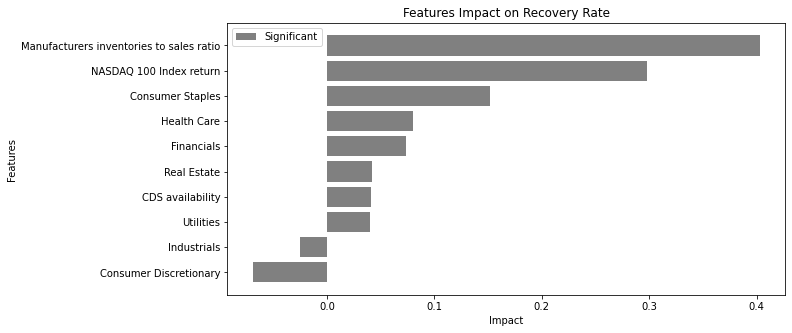

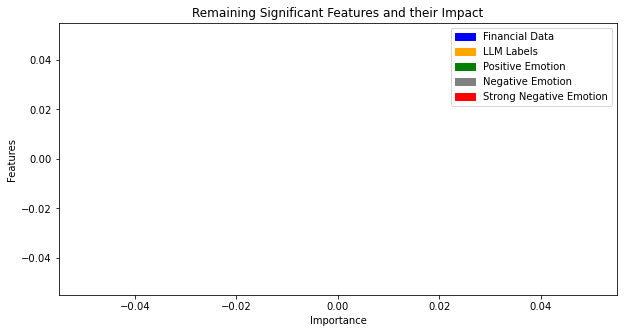

                                OLS Regression Results                               
Dep. Variable:     percentage_primary_dealer   R-squared:                       0.104
Model:                                   OLS   Adj. R-squared:                  0.081
Method:                        Least Squares   F-statistic:                     4.412
Date:                       Thu, 24 Oct 2024   Prob (F-statistic):           2.85e-12
Time:                               18:25:05   Log-Likelihood:                -125.96
No. Observations:                       1012   AIC:                             305.9
Df Residuals:                            985   BIC:                             438.8
Df Model:                                 26                                         
Covariance Type:                   nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

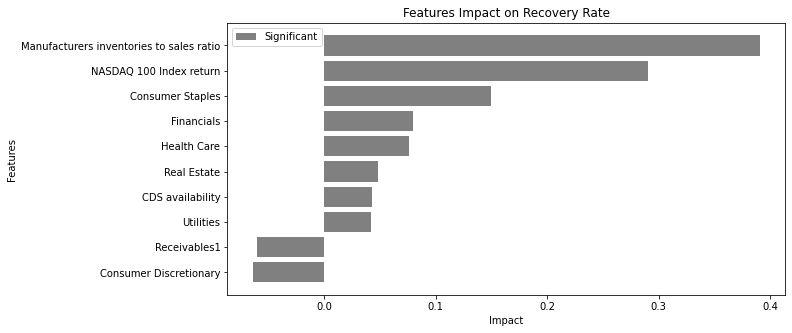

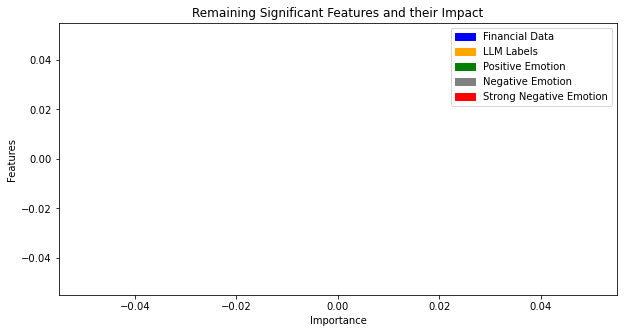

                                OLS Regression Results                               
Dep. Variable:     percentage_primary_dealer   R-squared:                       0.180
Model:                                   OLS   Adj. R-squared:                  0.157
Method:                        Least Squares   F-statistic:                     7.909
Date:                       Thu, 24 Oct 2024   Prob (F-statistic):           3.08e-16
Time:                               18:25:05   Log-Likelihood:                -95.990
No. Observations:                        558   AIC:                             224.0
Df Residuals:                            542   BIC:                             293.2
Df Model:                                 15                                         
Covariance Type:                   nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

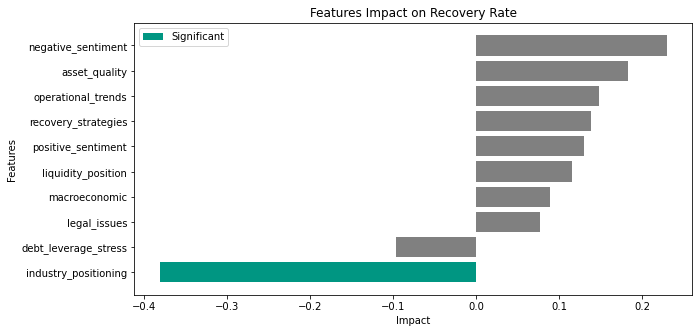

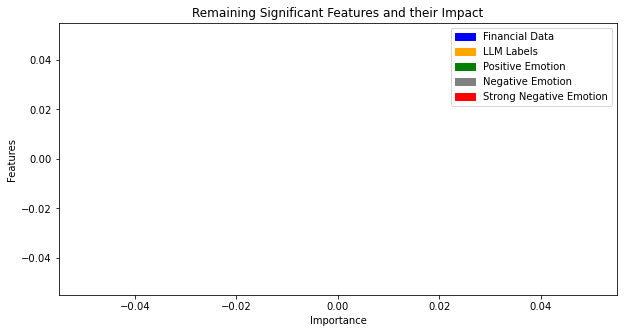

                                OLS Regression Results                               
Dep. Variable:     percentage_primary_dealer   R-squared:                       0.062
Model:                                   OLS   Adj. R-squared:                  0.048
Method:                        Least Squares   F-statistic:                     4.438
Date:                       Thu, 24 Oct 2024   Prob (F-statistic):           8.59e-05
Time:                               18:25:06   Log-Likelihood:                -124.06
No. Observations:                        475   AIC:                             264.1
Df Residuals:                            467   BIC:                             297.4
Df Model:                                  7                                         
Covariance Type:                   nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

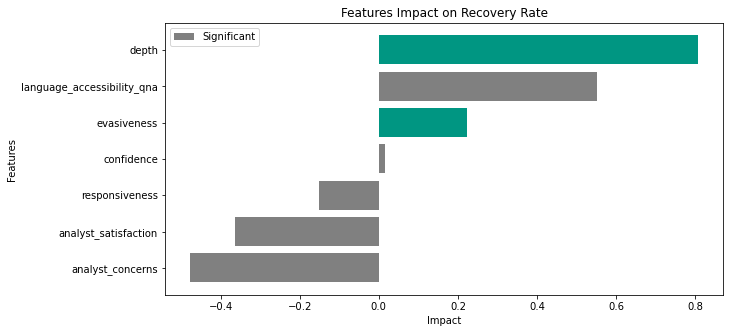

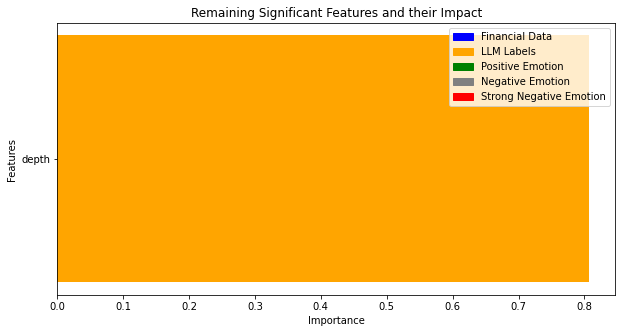

                                OLS Regression Results                               
Dep. Variable:     percentage_primary_dealer   R-squared:                       0.123
Model:                                   OLS   Adj. R-squared:                  0.087
Method:                        Least Squares   F-statistic:                     3.419
Date:                       Thu, 24 Oct 2024   Prob (F-statistic):           3.59e-07
Time:                               18:25:06   Log-Likelihood:                -114.62
No. Observations:                        559   AIC:                             275.2
Df Residuals:                            536   BIC:                             374.8
Df Model:                                 22                                         
Covariance Type:                   nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

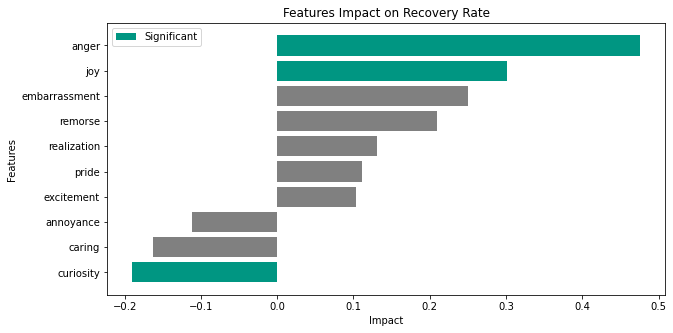

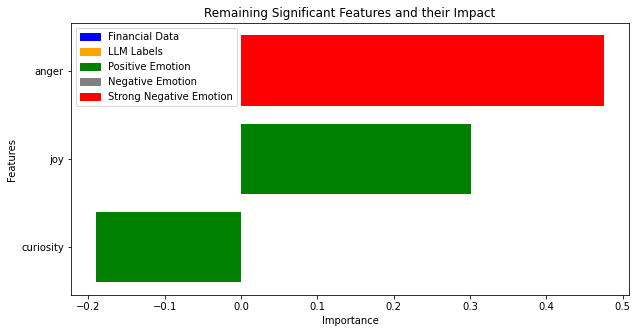

                                OLS Regression Results                               
Dep. Variable:     percentage_primary_dealer   R-squared:                       0.176
Model:                                   OLS   Adj. R-squared:                  0.143
Method:                        Least Squares   F-statistic:                     5.215
Date:                       Thu, 24 Oct 2024   Prob (F-statistic):           6.00e-13
Time:                               18:25:07   Log-Likelihood:                -97.116
No. Observations:                        559   AIC:                             240.2
Df Residuals:                            536   BIC:                             339.7
Df Model:                                 22                                         
Covariance Type:                   nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

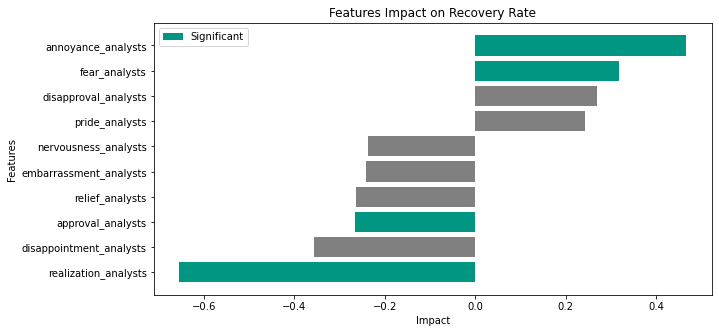

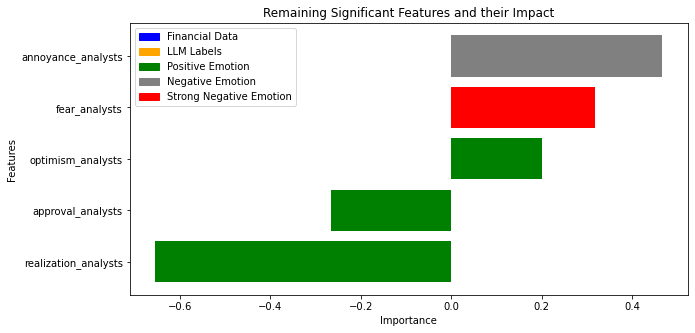

                                OLS Regression Results                               
Dep. Variable:     percentage_primary_dealer   R-squared:                       0.184
Model:                                   OLS   Adj. R-squared:                  0.151
Method:                        Least Squares   F-statistic:                     5.512
Date:                       Thu, 24 Oct 2024   Prob (F-statistic):           6.44e-14
Time:                               18:25:07   Log-Likelihood:                -94.328
No. Observations:                        559   AIC:                             234.7
Df Residuals:                            536   BIC:                             334.2
Df Model:                                 22                                         
Covariance Type:                   nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

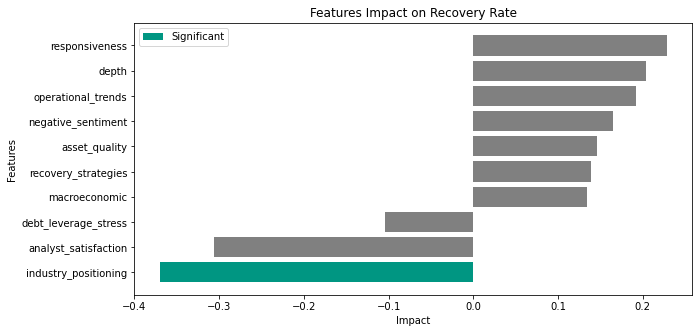

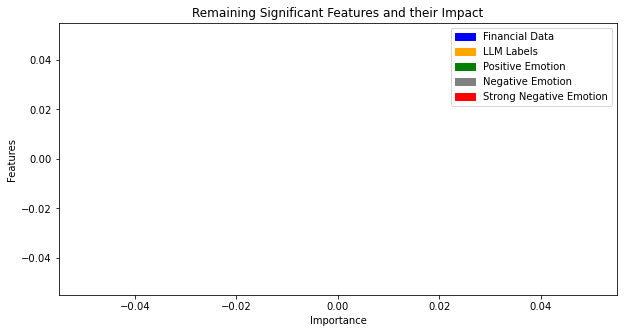

                                OLS Regression Results                               
Dep. Variable:     percentage_primary_dealer   R-squared:                       0.204
Model:                                   OLS   Adj. R-squared:                  0.136
Method:                        Least Squares   F-statistic:                     2.993
Date:                       Thu, 24 Oct 2024   Prob (F-statistic):           3.02e-09
Time:                               18:25:07   Log-Likelihood:                -87.565
No. Observations:                        559   AIC:                             265.1
Df Residuals:                            514   BIC:                             459.8
Df Model:                                 44                                         
Covariance Type:                   nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

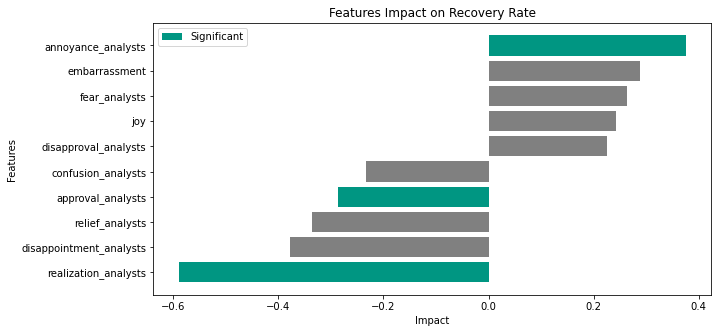

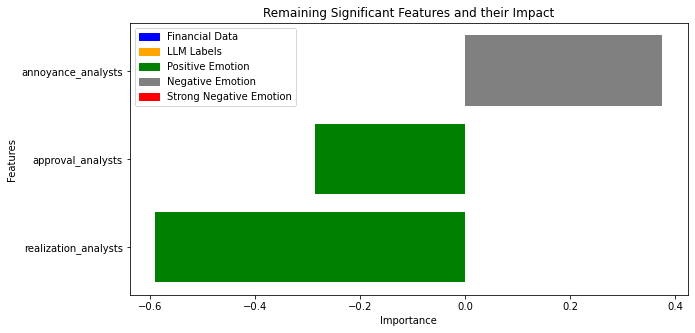

                                OLS Regression Results                               
Dep. Variable:     percentage_primary_dealer   R-squared:                       0.254
Model:                                   OLS   Adj. R-squared:                  0.154
Method:                        Least Squares   F-statistic:                     2.537
Date:                       Thu, 24 Oct 2024   Prob (F-statistic):           6.99e-09
Time:                               18:25:08   Log-Likelihood:                -69.469
No. Observations:                        559   AIC:                             272.9
Df Residuals:                            492   BIC:                             562.8
Df Model:                                 66                                         
Covariance Type:                   nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

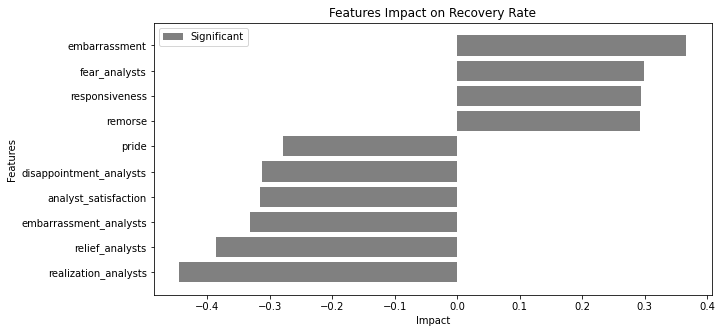

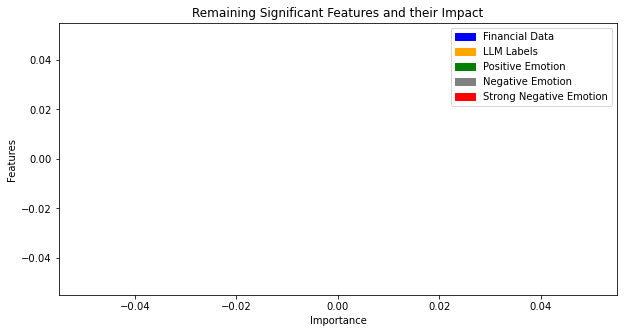

                                OLS Regression Results                               
Dep. Variable:     percentage_primary_dealer   R-squared:                       0.121
Model:                                   OLS   Adj. R-squared:                  0.084
Method:                        Least Squares   F-statistic:                     3.263
Date:                       Thu, 24 Oct 2024   Prob (F-statistic):           7.54e-11
Time:                               18:25:08   Log-Likelihood:                -116.33
No. Observations:                       1012   AIC:                             316.7
Df Residuals:                            970   BIC:                             523.3
Df Model:                                 41                                         
Covariance Type:                   nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

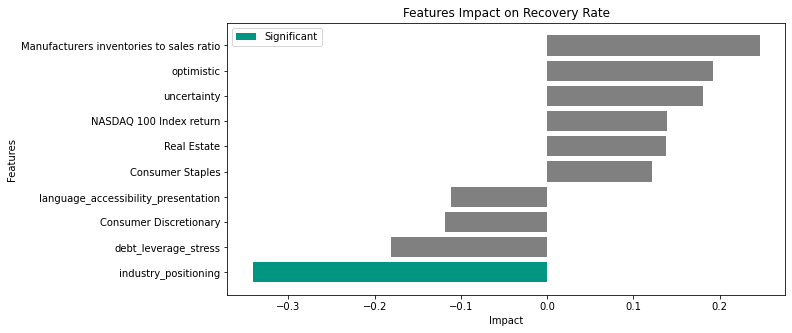

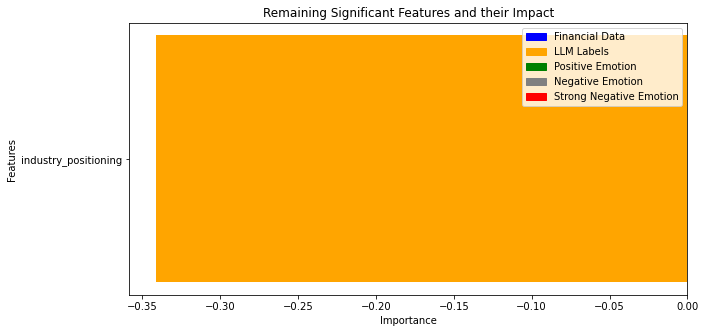

                                OLS Regression Results                               
Dep. Variable:     percentage_primary_dealer   R-squared:                       0.112
Model:                                   OLS   Adj. R-squared:                  0.082
Method:                        Least Squares   F-statistic:                     3.743
Date:                       Thu, 24 Oct 2024   Prob (F-statistic):           1.65e-11
Time:                               18:25:09   Log-Likelihood:                -121.52
No. Observations:                       1012   AIC:                             311.0
Df Residuals:                            978   BIC:                             478.3
Df Model:                                 33                                         
Covariance Type:                   nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

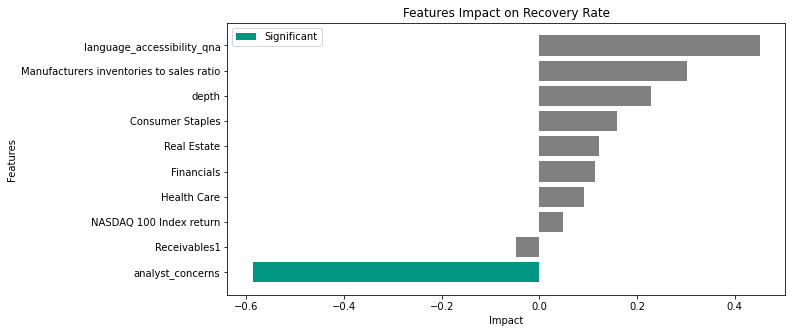

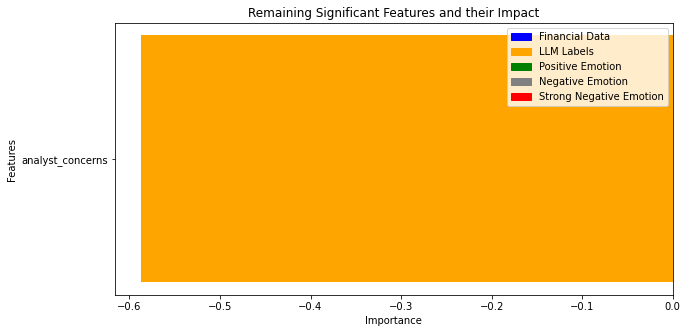

                                OLS Regression Results                               
Dep. Variable:     percentage_primary_dealer   R-squared:                       0.128
Model:                                   OLS   Adj. R-squared:                  0.085
Method:                        Least Squares   F-statistic:                     2.948
Date:                       Thu, 24 Oct 2024   Prob (F-statistic):           3.20e-10
Time:                               18:25:09   Log-Likelihood:                -112.33
No. Observations:                       1012   AIC:                             322.7
Df Residuals:                            963   BIC:                             563.7
Df Model:                                 48                                         
Covariance Type:                   nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

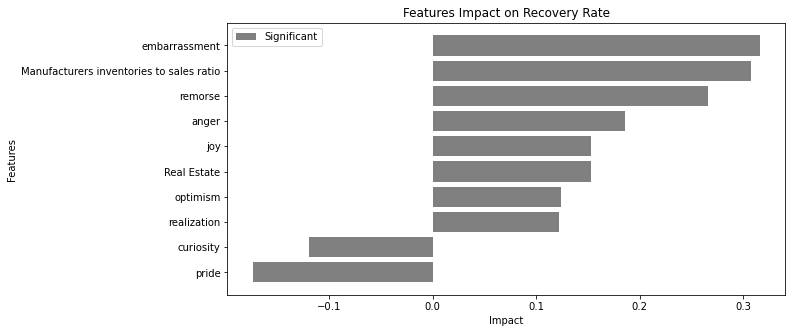

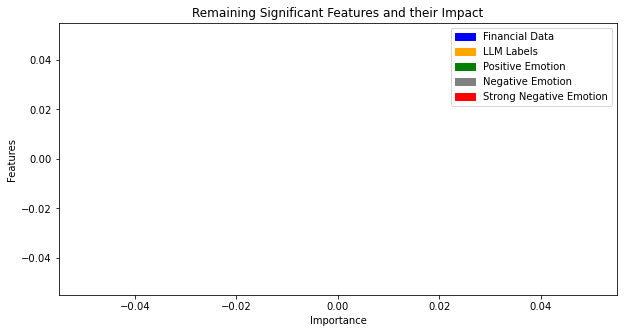

                                OLS Regression Results                               
Dep. Variable:     percentage_primary_dealer   R-squared:                       0.134
Model:                                   OLS   Adj. R-squared:                  0.091
Method:                        Least Squares   F-statistic:                     3.112
Date:                       Thu, 24 Oct 2024   Prob (F-statistic):           3.01e-11
Time:                               18:25:10   Log-Likelihood:                -108.74
No. Observations:                       1012   AIC:                             315.5
Df Residuals:                            963   BIC:                             556.5
Df Model:                                 48                                         
Covariance Type:                   nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

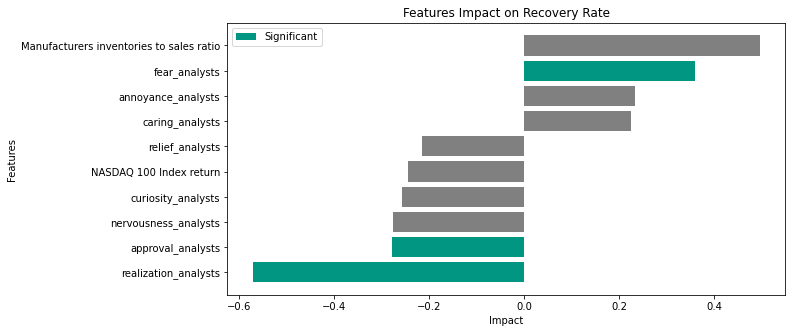

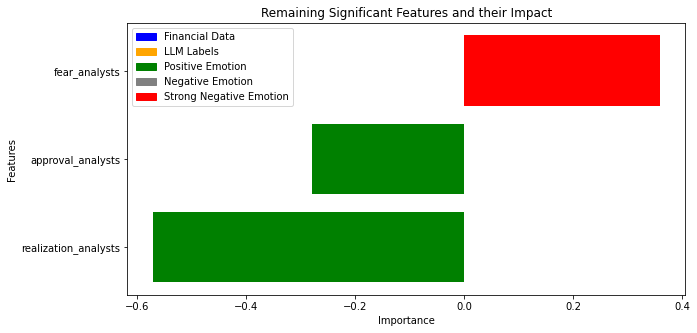

                                OLS Regression Results                               
Dep. Variable:     percentage_primary_dealer   R-squared:                       0.127
Model:                                   OLS   Adj. R-squared:                  0.083
Method:                        Least Squares   F-statistic:                     2.909
Date:                       Thu, 24 Oct 2024   Prob (F-statistic):           5.56e-10
Time:                               18:25:10   Log-Likelihood:                -113.19
No. Observations:                       1012   AIC:                             324.4
Df Residuals:                            963   BIC:                             565.4
Df Model:                                 48                                         
Covariance Type:                   nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

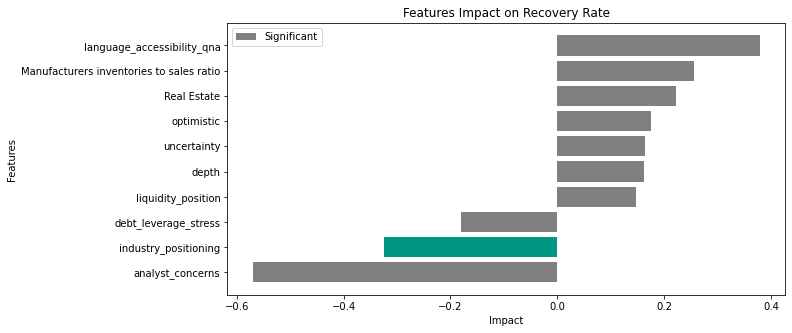

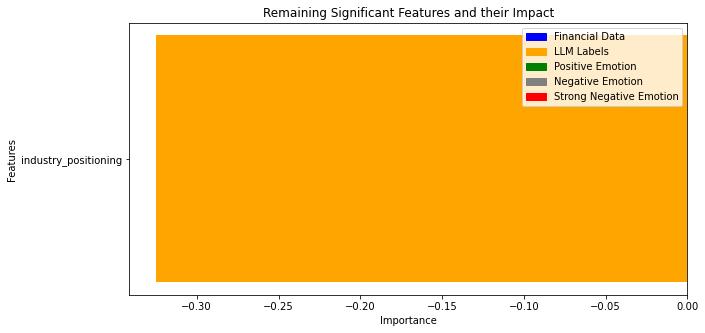

                                OLS Regression Results                               
Dep. Variable:     percentage_primary_dealer   R-squared:                       0.152
Model:                                   OLS   Adj. R-squared:                  0.089
Method:                        Least Squares   F-statistic:                     2.403
Date:                       Thu, 24 Oct 2024   Prob (F-statistic):           4.95e-09
Time:                               18:25:11   Log-Likelihood:                -98.483
No. Observations:                       1012   AIC:                             339.0
Df Residuals:                            941   BIC:                             688.3
Df Model:                                 70                                         
Covariance Type:                   nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

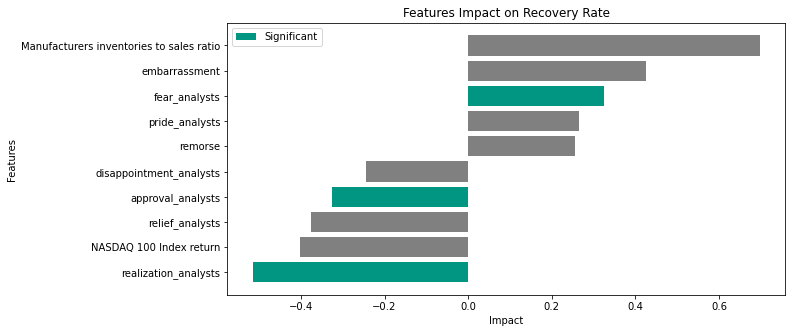

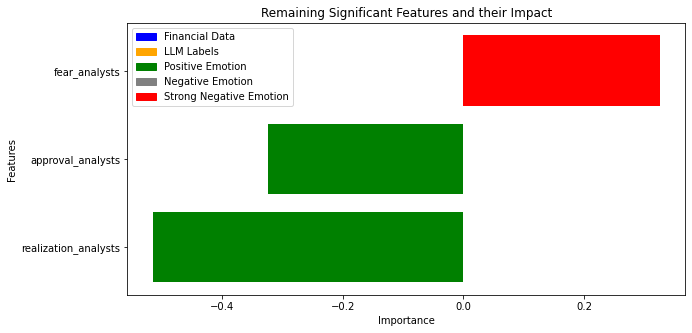

                                OLS Regression Results                               
Dep. Variable:     percentage_primary_dealer   R-squared:                       0.164
Model:                                   OLS   Adj. R-squared:                  0.080
Method:                        Least Squares   F-statistic:                     1.957
Date:                       Thu, 24 Oct 2024   Prob (F-statistic):           8.08e-07
Time:                               18:25:11   Log-Likelihood:                -91.178
No. Observations:                       1012   AIC:                             368.4
Df Residuals:                            919   BIC:                             825.9
Df Model:                                 92                                         
Covariance Type:                   nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

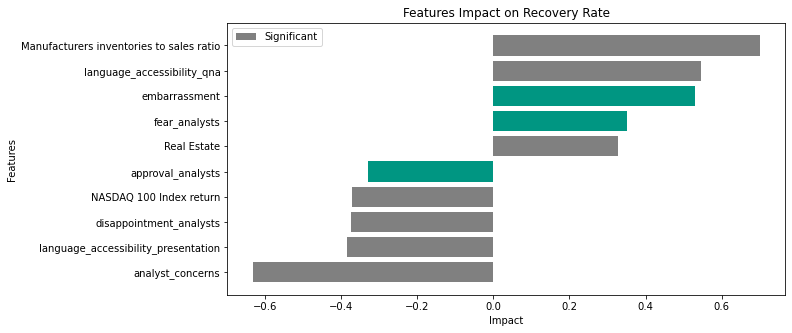

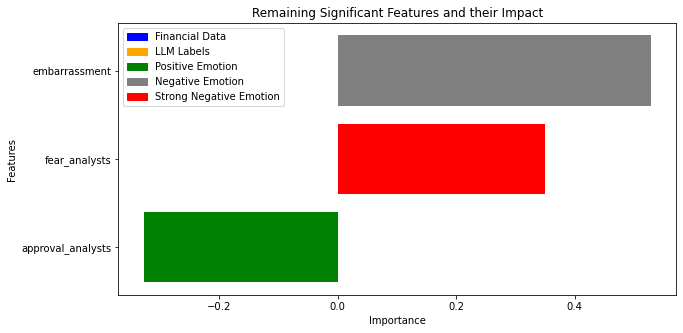

In [102]:
for key in feature_sets:

    final_df = dealer_df[['percentage_primary_dealer']+ feature_sets[key]]
    final_df = final_df.drop_duplicates()

    # Define features and target variable
    X = final_df.drop(columns='percentage_primary_dealer')
    y = final_df['percentage_primary_dealer']

    # Split into training and test sets
    X_train, X_test, y_train, y_test = X, X, y, y
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # Fit the model
    model = sm.OLS(y_train, X_train).fit()

    # Print the summary of the model which includes p-values and significance levels
    print(model.summary())

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute and print evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"R-squared: {r2}")

    create_significant_chart(model)
    create_colored_chart(model)